In [1]:
import pandas as pd
import re
import pyarrow
from datetime import datetime, timedelta

Read in Data

In [3]:
# File Path Configuration
filepaths = [
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6863_Paraquita/6863_Paraquita_Raven/BVI_mangroves_6863_20240115_174358.diversity.selections.txt",
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6879_French/6879_French_Raven/BVI_mangroves_6879_20240115_151620_list.diversity.selections.txt",
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6880_HansA/6880_HansA_Raven/BVI_mangroves_6880_20240116_162417_list.diversity.selections.txt",
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6884_SeaCowBay/6884_SeaCowBay_Raven/BVI_mangroves_6864_20240114_194526.diversity.selections.txt"
]

# --- Initialize List for DataFrames ---
dfs = []

# --- Loop Through Files, Read, and Initial Processing ---
for file in filepaths:
    df = pd.read_csv(file, sep='\t', engine='python')
    df['file'] = file

    # Drop Unwanted Columns
    df = df.drop(columns=['Channel', 'From', 'Tags', 'View'], errors='ignore')

    # Rename Columns
    rename_cols = {
        'Selection': 'selection',
        'Begin Time (s)': 'begin_time_s',
        'End Time (s)': 'end_time_s',
        'Low Freq (Hz)': 'low_freq_hz',
        'High Freq (Hz)': 'high_freq_hz',
        'Begin Path': 'begin_path',
        'File Offset (s)': 'file_offset_s',
        'Peak Freq (Hz)': 'peak_freq_hz',
        'Label': 'label'
    }
    df = df.rename(columns=rename_cols)

    dfs.append(df)

# --- Combine All DataFrames ---
df = pd.concat(dfs, ignore_index=True)

Prepare data

In [4]:
# Extract the hydrophone number (list as site)
df['site'] = df['file'].str.extract(r'BVI_mangroves_(\d{4})_').astype(float)

# Extract Date, Time, and Hour from 'begin_path' Filename
date_time_match = df['begin_path'].str.extract(r'(\d{8})_(\d{6})')

if date_time_match.notna().all().all():
    df['extracted_date_str'] = date_time_match[0]
    df['extracted_time_str'] = date_time_match[1]
    df['extracted_datetime'] = pd.to_datetime(df['extracted_date_str'] + df['extracted_time_str'], format='%Y%m%d%H%M%S')

    # Add 'file_offset_s' as a Timedelta
    df['adjusted_datetime'] = df['extracted_datetime'] + pd.to_timedelta(df['file_offset_s'], unit='s')

    # Update 'date', 'time', and 'hour' from the adjusted datetime
    df['date'] = df['adjusted_datetime'].dt.date
    df['time'] = df['adjusted_datetime'].dt.strftime('%H%M%S')
    df['hour'] = df['adjusted_datetime'].dt.hour.astype(float)

    # Drop temporary columns
    df = df.drop(columns=['extracted_date_str', 'extracted_time_str', 'extracted_datetime', 'adjusted_datetime'])
else:
    print("Warning: Could not extract date and time information from the filename in 'begin_path' in all rows. Please check the format.")
    df['date'] = pd.NaT
    df['time'] = None
    df['hour'] = None

# --- Create 'tod' Column based on 'hour' ---
def get_tod(hour):
    if hour in [3, 4, 5]:
        return 'midnight'
    elif hour in [9, 10, 11]:
        return 'sunrise'
    elif hour in [15, 16, 17]:
        return 'noon'
    elif hour in [19, 20, 21, 22, 23]:
        return 'sunset'
    return None

df['tod'] = df['hour'].apply(get_tod)

# --- Summarize 'tod' counts by 'date' and 'site' ---
tod_summary = df.groupby(['date', 'site', 'tod']).size().unstack(fill_value=0)

# --- Display the Summary ---
print("\nSummary of Time of Day (tod) counts by Date and Site (Adjusted Time from begin_path filename):")
print(tod_summary)

# --- Display Results ---
print("\nHead of the processed DataFrame (Adjusted Time from begin_path filename):")
print(df.head())
print("\nColumns of the processed DataFrame:")
print(df.columns)


Summary of Time of Day (tod) counts by Date and Site (Adjusted Time from begin_path filename):
tod                midnight  noon  sunrise  sunset
date       site                                   
2024-01-15 6864.0         1    23       12       1
2024-01-16 6863.0         1     4        0       1
           6864.0         0     9        4       1
           6879.0        12    19       15      39
           6880.0         0     0        0       2
...                     ...   ...      ...     ...
2024-02-22 6863.0         0     2        7       0
2024-02-23 6863.0         0    10        2       0
2024-02-24 6863.0         0     3        0       0
2024-02-25 6863.0         0     4        4       0
2024-02-26 6863.0         0    31       21       0

[87 rows x 4 columns]

Head of the processed DataFrame (Adjusted Time from begin_path filename):
   selection  begin_time_s   end_time_s  low_freq_hz  high_freq_hz  \
0        117   70396.97342  70397.38954      186.441      2175.141   
1  

In [5]:
# Save the main DataFrame to CSV or parquet
df.to_parquet('/Users/jillmunger/Desktop/UNH/research/diversity/div_data.parquet', index=False)

# df.to_csv('/Users/jillmunger/Desktop/UNH/research/diversity/div_data.parquet', index=False)

Begin diversity analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read in df from parquet file
df = pd.read_parquet('/Users/jillmunger/Desktop/UNH/research/diversity/div_data.parquet')

In [25]:
# Dictionary mapping site numbers to site names
site_mapping = {
    6863: 'paraquita',
    6879: 'french',
    6880: 'hans',
    6864: 'scb'
}

# Recovery mapping
recovery_mapping = {
    'hans': 'recovered',
    'paraquita': 'recovered',
    'french': 'recovering',
    'scb': 'degraded'
}

# Mangrove-inspired palette
mangrove_palette = ["#2E8B57", "#8B4513", "#BDB76B", "#ADD8E6"] # DeepGreen, SaddleBrown, DarkKhaki, LightBlue

# Caribbean fish-inspired palette
fish_palette = ["#00CED1", "#4682B4", "#FFA500", "#FF4500"] # DarkTurquoise (healthy), SteelBlue (healthy) Orange (recovering), OrangeRed (degraded)

# 1. Group and Count
grouped = df.groupby(['site', 'tod', 'sound_type']).size().unstack(fill_value=0)

# 2. Abundance
abundance = grouped

# 3. Richness
richness = grouped.astype(bool).sum(axis=1)

# 4. Exponential Shannon
def shannon_diversity(counts):
    total = counts.sum()
    proportions = counts / total
    proportions = proportions[proportions > 0]  # Avoid log(0)
    return np.exp(-np.sum(proportions * np.log(proportions)))

shannon = grouped.apply(shannon_diversity, axis=1)

# 5. Inverse Simpson
def simpson_diversity(counts):
    total = counts.sum()
    proportions = counts / total
    return 1 / np.sum(proportions**2)

simpson = grouped.apply(simpson_diversity, axis=1)

# 6. Combine Metrics
metrics = pd.DataFrame({
    'noisy_abundance': abundance['noisy'],
    'sp_abundance': abundance['sp'],
    'train_abundance': abundance['train'],
    'richness': richness,
    'shannon': shannon,
    'simpson': simpson
})

metrics = metrics.reset_index() #make site and tod columns instead of index

# Map site numbers to site names
metrics['site'] = metrics['site'].map(site_mapping)

# Add recovery column
metrics['recovery'] = metrics['site'].map(recovery_mapping)

Visualize

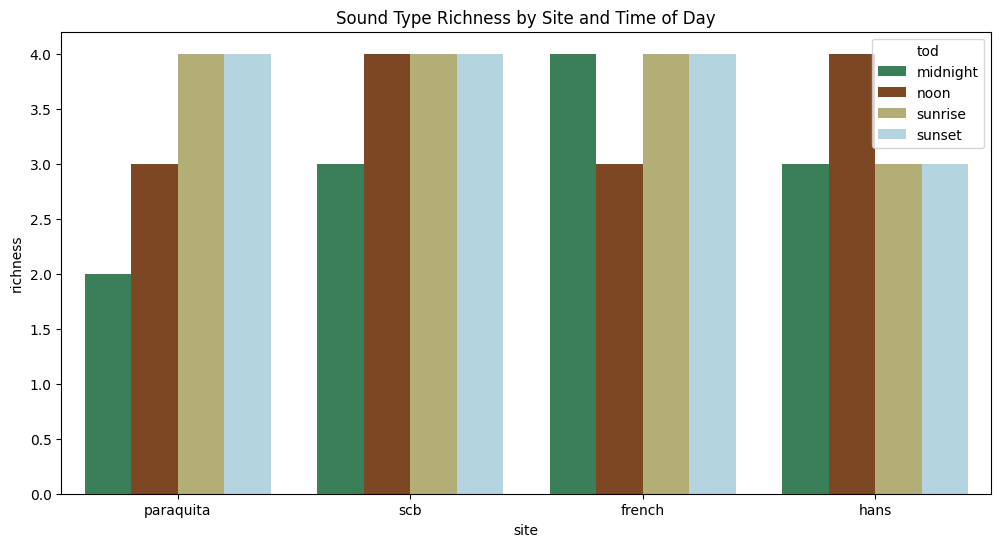

/var/folders/49/g8x588256sv4740wwgn3d1tr0000gn/T/ipykernel_41739/781617864.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='site', y='shannon', data=metrics, palette=fish_palette)


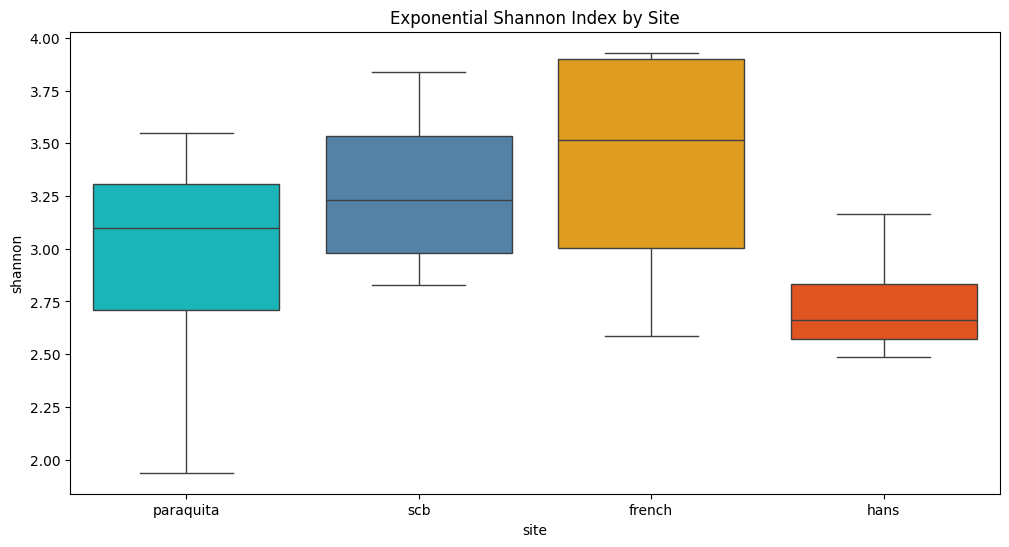

/var/folders/49/g8x588256sv4740wwgn3d1tr0000gn/T/ipykernel_41739/781617864.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='site', y='simpson', data=metrics, palette=fish_palette)


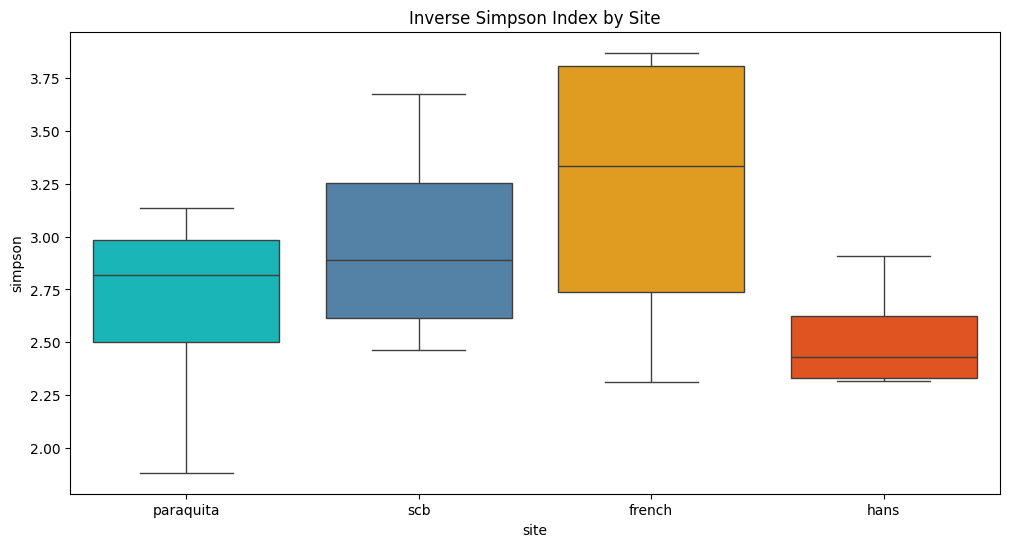

/var/folders/49/g8x588256sv4740wwgn3d1tr0000gn/T/ipykernel_41739/781617864.py:24: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.barplot(x = 'site', y = 'abundance', hue = 'sound_type', data = abundance_melted, palette=fish_palette)


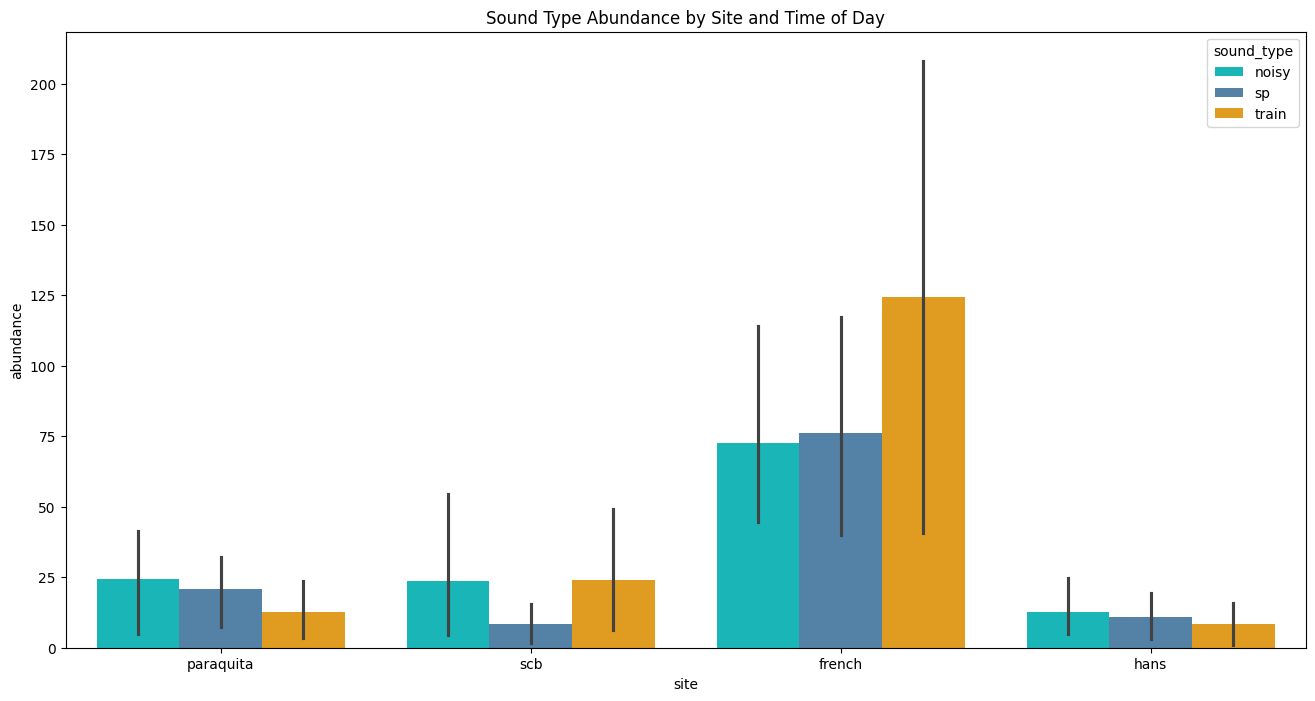

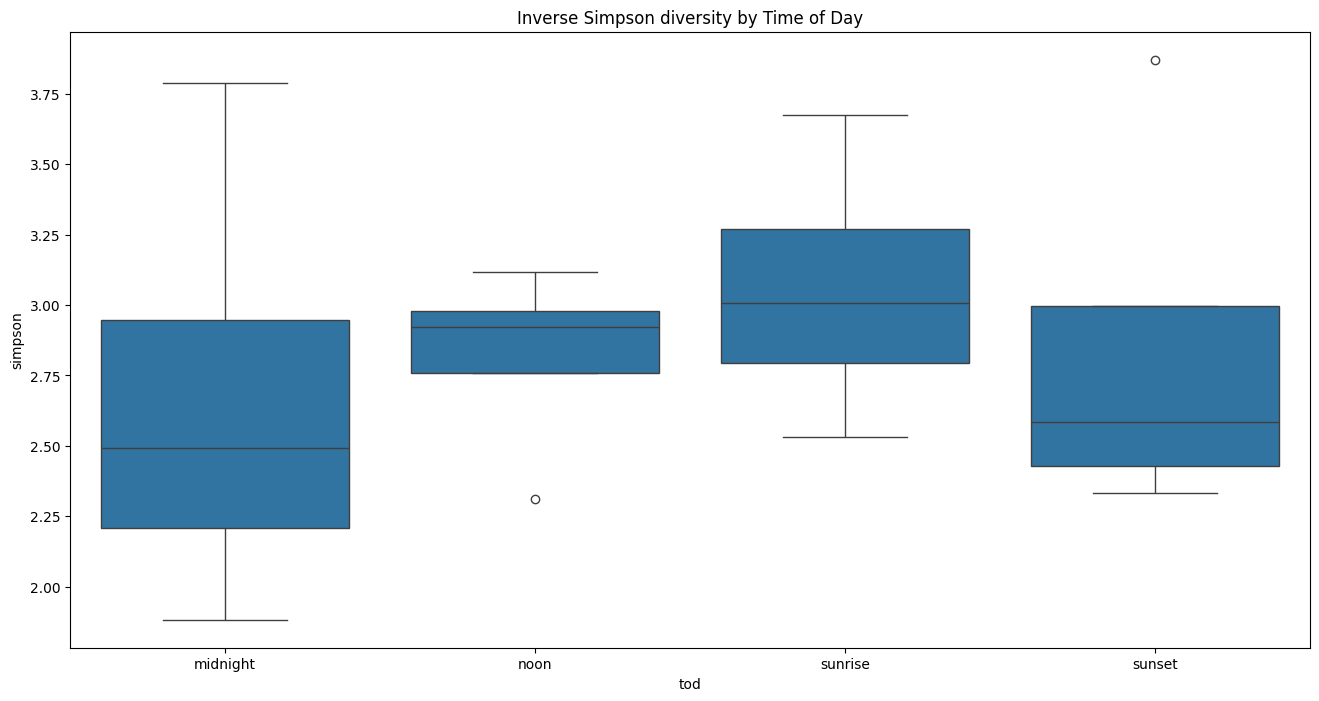

In [31]:
# Bar plots for richness by site and tod
plt.figure(figsize=(12, 6))
sns.barplot(x='site', y='richness', hue='tod', data=metrics, palette=mangrove_palette)
plt.title('Sound Type Richness by Site and Time of Day')
plt.show()

# Box plot for Shannon by site
plt.figure(figsize=(12, 6))
sns.boxplot(x='site', y='shannon', data=metrics, palette=fish_palette)
plt.title('Exponential Shannon Index by Site')
plt.show()

# Box plot for Simpson by site
plt.figure(figsize=(12, 6))
sns.boxplot(x='site', y='simpson', data=metrics, palette=fish_palette)
plt.title('Inverse Simpson Index by Site')
plt.show()

# Barplot for abundance of each sound type by site and tod
abundance_melted = metrics.melt(id_vars=['site','tod'], value_vars = ['noisy_abundance','sp_abundance','train_abundance'], var_name = 'sound_type', value_name = 'abundance')
abundance_melted['sound_type'] = abundance_melted['sound_type'].str.replace('_abundance','')

plt.figure(figsize = (16,8))
sns.barplot(x = 'site', y = 'abundance', hue = 'sound_type', data = abundance_melted, palette=fish_palette)
plt.title('Sound Type Abundance by Site and Time of Day')
plt.show()

# Box plot for simpson diversity by tod
plt.figure(figsize = (16,8))
sns.boxplot(x = 'tod', y = 'simpson', data = metrics)
plt.title('Inverse Simpson diversity by Time of Day')
plt.show()

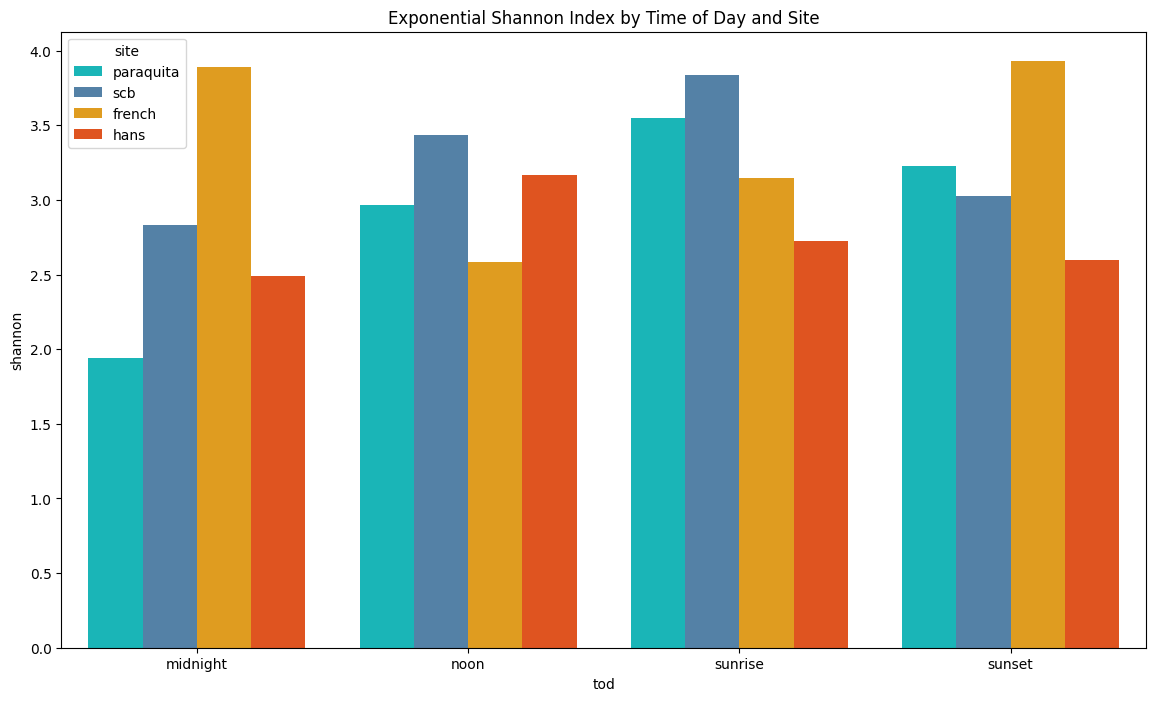

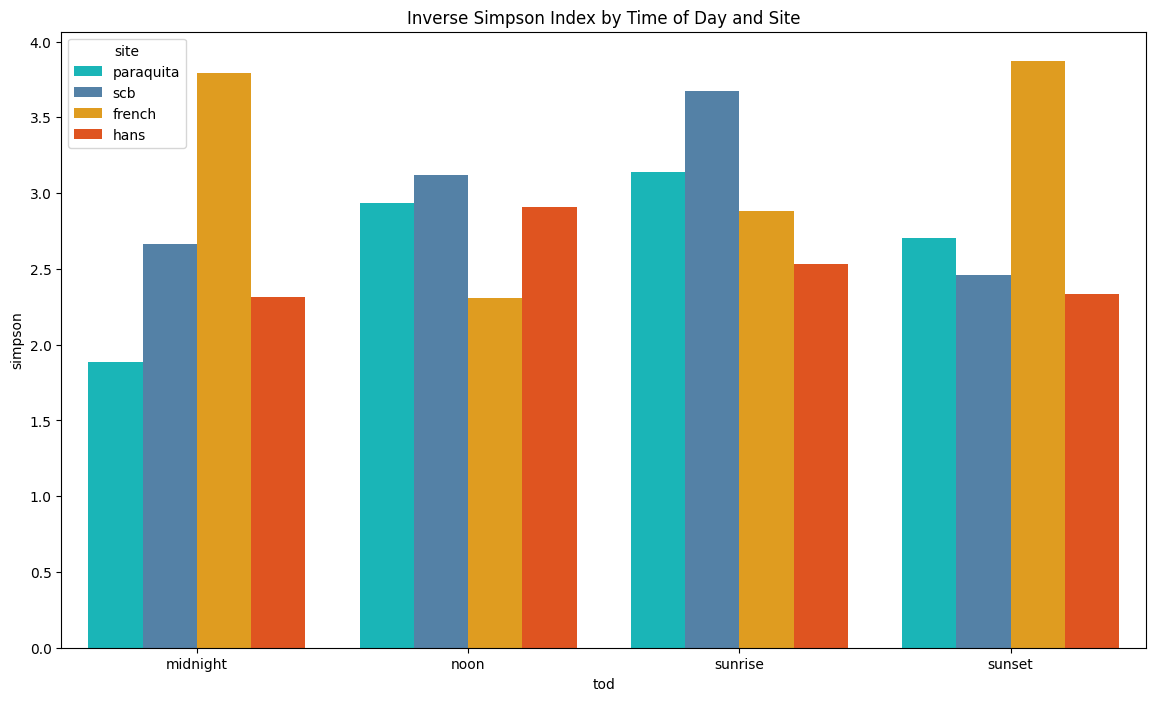

/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/diversity/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/diversity/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/diversity/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/diversity/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  func(*plot_args, **plot_

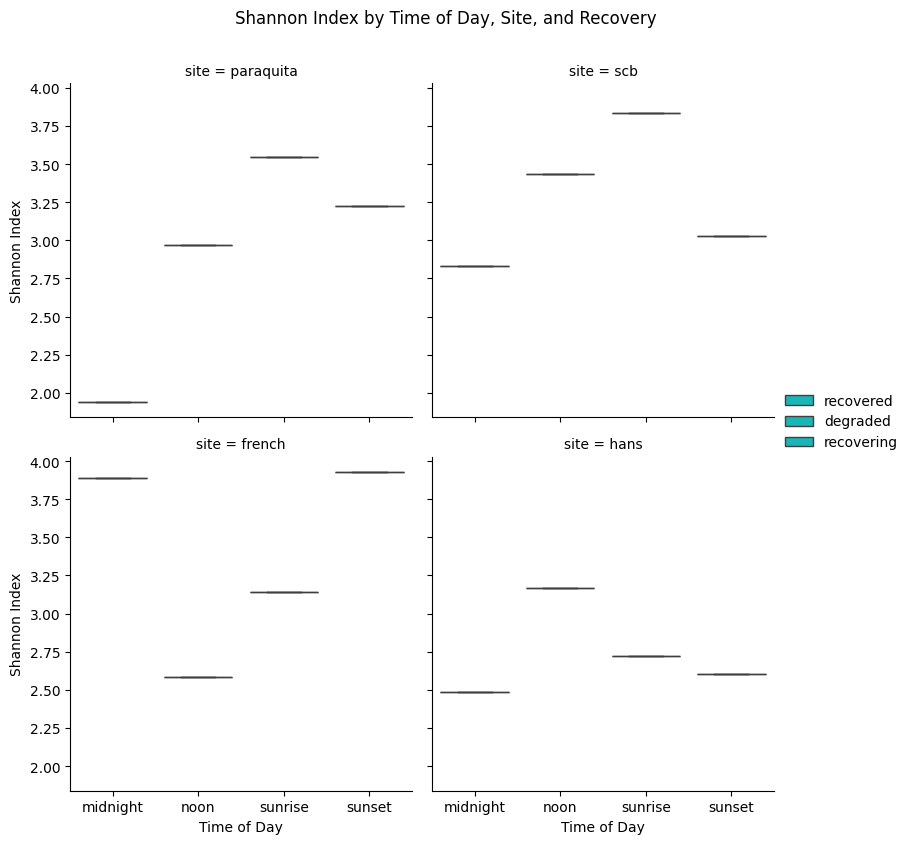

/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/diversity/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/diversity/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/diversity/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/diversity/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  func(*plot_args, **plot_

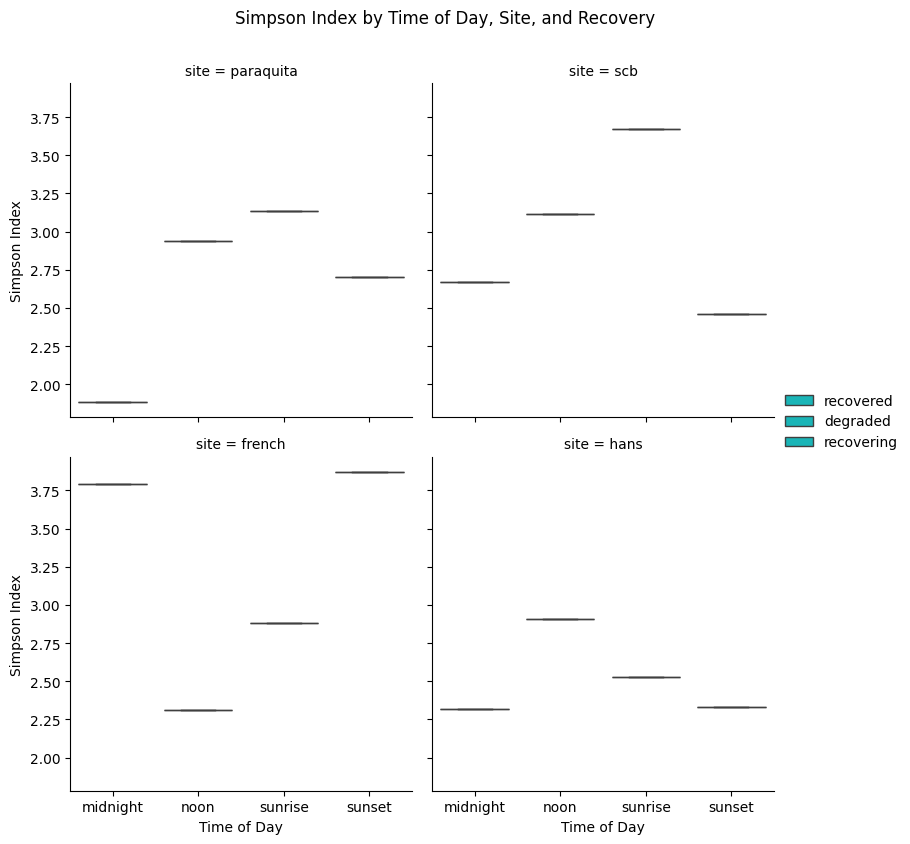

In [26]:
# Box plot for Shannon by Time of Day and Site
plt.figure(figsize=(14, 8))
sns.barplot(x='tod', y='shannon', hue='site', data=metrics, palette=fish_palette)
plt.title('Exponential Shannon Index by Time of Day and Site')
plt.show()

# Box plot for Simpson by Time of Day and Site
plt.figure(figsize=(14, 8))
sns.barplot(x='tod', y='simpson', hue='site', data=metrics, palette=fish_palette)
plt.title('Inverse Simpson Index by Time of Day and Site')
plt.show()

# Faceted Box plot for Shannon by Time of Day and Site with Recovery
g = sns.FacetGrid(metrics, col='site', col_wrap=2, height=4)
g.map(sns.boxplot, 'tod', 'shannon', 'recovery', palette=fish_palette)
g.add_legend()
g.set_axis_labels('Time of Day', 'Shannon Index')
g.fig.suptitle('Shannon Index by Time of Day, Site, and Recovery', y=1.05)
plt.show()

# Faceted Box plot for Simpson by Time of Day and Site with Recovery
g2 = sns.FacetGrid(metrics, col='site', col_wrap=2, height=4)
g2.map(sns.boxplot, 'tod', 'simpson', 'recovery', palette=fish_palette)
g2.add_legend()
g2.set_axis_labels('Time of Day', 'Simpson Index')
g2.fig.suptitle('Simpson Index by Time of Day, Site, and Recovery', y=1.05)
plt.show()

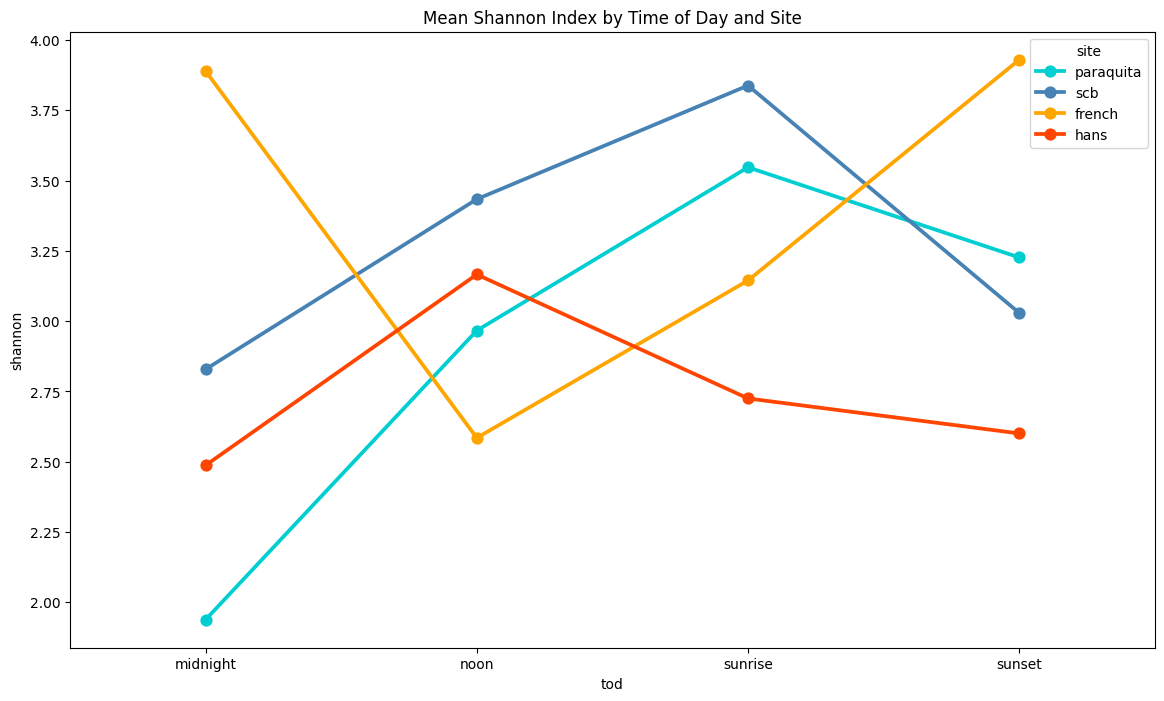

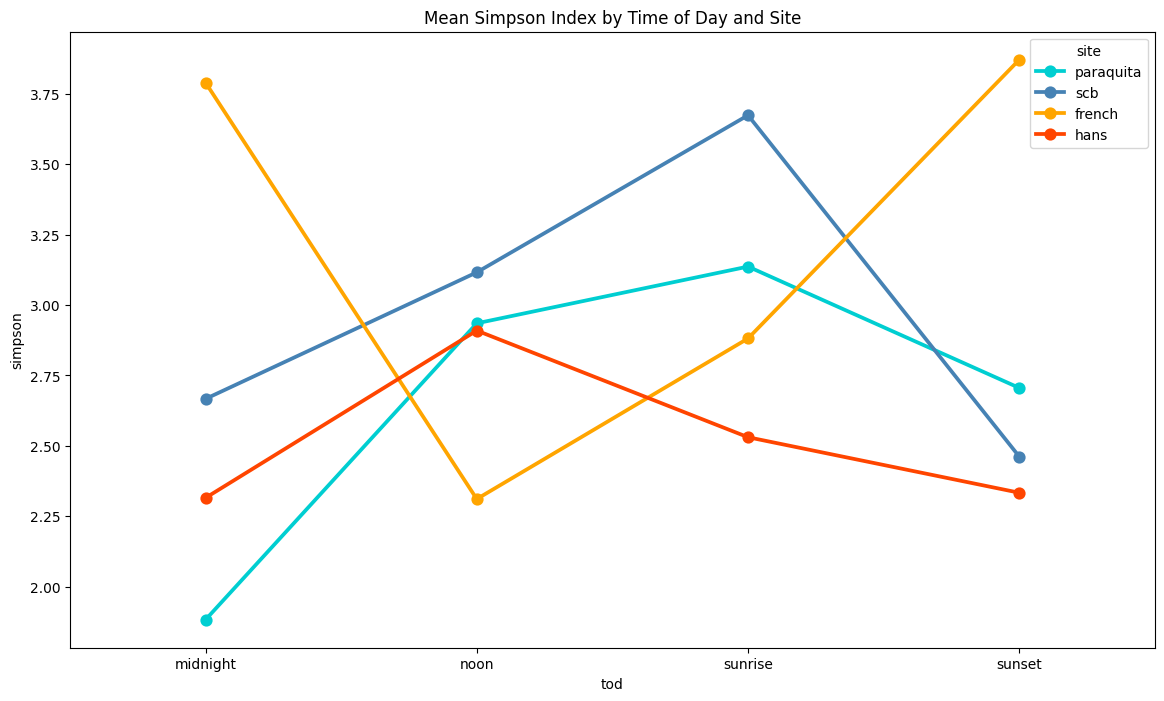

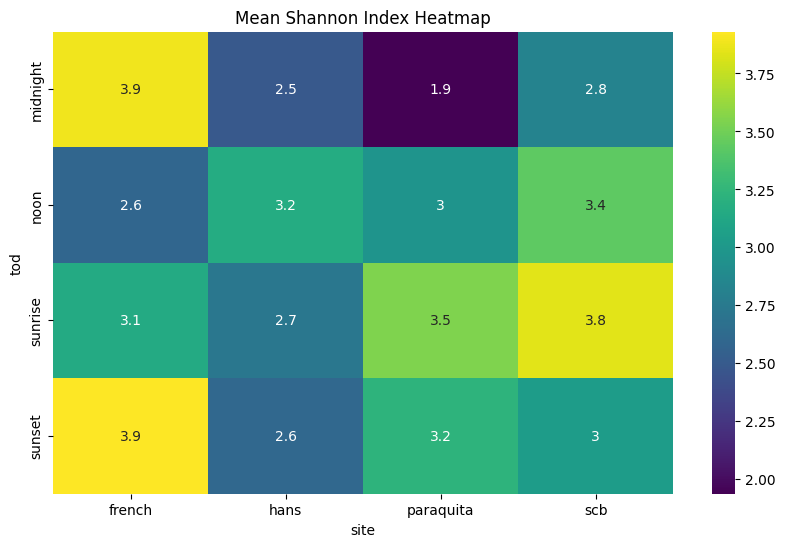

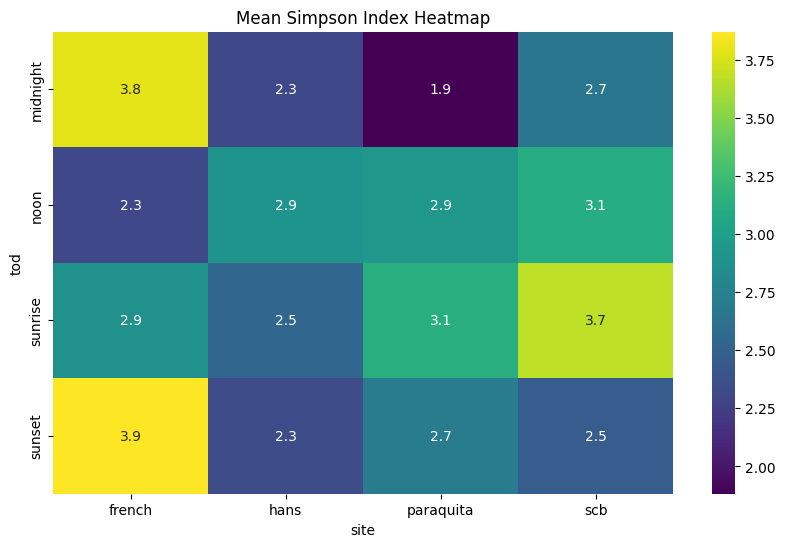

In [36]:
# Point Plots
plt.figure(figsize=(14, 8))
sns.pointplot(x='tod', y='shannon', hue='site', data=metrics, palette=fish_palette)
plt.title('Mean Shannon Index by Time of Day and Site')
plt.show()

# Point Plots
plt.figure(figsize=(14, 8))
sns.pointplot(x='tod', y='simpson', hue='site', data=metrics, palette=fish_palette)
plt.title('Mean Simpson Index by Time of Day and Site')
plt.show()

# Heatmap
heatmap_data = metrics.pivot_table(index='tod', columns='site', values='shannon', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis')
plt.title('Mean Shannon Index Heatmap')
plt.show()

# Heatmap
heatmap_data = metrics.pivot_table(index='tod', columns='site', values='simpson', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis')
plt.title('Mean Simpson Index Heatmap')
plt.show()